In [9]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import math
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
sns.set(font_scale=2)
pylab.rcParams['figure.figsize'] = (24, 18)

names=['ENI','SAN','SAF','BNP','ACA']
df=pd.DataFrame()
for i in names:
    df[i]=quandl.get('EURONEXT/'+i,token=token).Last



In [10]:
## Take a random subsection of stocks

df.head()

,ENI,SAN,SAF,BNP,ACA
Date,,,,,
2014-02-13,16.92,NaN,NaN,NaN,NaN
2014-02-17,17.26,73.01,54.27,58.45,10.795
2014-02-18,17.35,73.21,53.81,58.38,10.790
2014-02-20,17.46,73.57,52.43,58.52,11.175
2014-02-21,17.54,74.00,52.00,58.63,11.090


In [40]:
ret = (df.pct_change(1)+1).dropna()

In [88]:
ret.head()

,ENI,SAN,SAF,BNP,ACA
Date,,,,,
2014-02-18,1.005214,1.002739,0.991524,0.998802,0.999537
2014-02-20,1.006340,1.004917,0.974354,1.002398,1.035681
2014-02-21,1.004582,1.005845,0.991799,1.001880,0.992394
2014-02-24,0.992018,1.008784,0.979423,1.012110,1.014427
2014-02-25,1.000000,0.998259,0.995484,1.002696,0.999556


In [146]:
strategy = ((df-df.shift(14))/df.shift(14)).iloc[::14, :].dropna().abs()

In [147]:
allocation = strategy.div(strategy.sum(axis=1), axis=0)

In [148]:
df2 = pd.DataFrame(index=df.index)
alloc = pd.merge(df2, allocation, left_index=True, right_index=True,how="left")

In [149]:
alloc.ffill(inplace=True)

In [150]:
alloc = alloc.dropna()

In [151]:
alloc.iloc[0,:] = 1/len(alloc.columns)

In [152]:
alloc.head()

,ENI,SAN,SAF,BNP,ACA
Date,,,,,
2014-04-09,0.200000,0.200000,0.200000,0.20000,0.200000
2014-04-11,0.309835,0.350026,0.211444,0.06804,0.060655
2014-04-14,0.309835,0.350026,0.211444,0.06804,0.060655
2014-04-15,0.309835,0.350026,0.211444,0.06804,0.060655
2014-04-16,0.309835,0.350026,0.211444,0.06804,0.060655


In [153]:
## set the first one equal to one 
ret.loc[alloc.iloc[0,:].to_frame().columns.values[0],:]=1

In [154]:
alloc_ret = alloc*ret

In [155]:
alloc_ret.dropna(inplace=True)

In [156]:
alloc_ret["Return"] = alloc_ret.sum(axis=1)

In [157]:
alloc_ret.head()

,ENI,SAN,SAF,BNP,ACA,Return
Date,,,,,,
2014-04-09,0.200000,0.200000,0.200000,0.200000,0.200000,1.000000
2014-04-11,0.309835,0.340595,0.209863,0.065792,0.058643,0.984728
2014-04-14,0.311203,0.353038,0.208455,0.067644,0.059763,1.000103
2014-04-15,0.314091,0.345315,0.210183,0.066609,0.059667,0.995865
2014-04-16,0.310675,0.353573,0.218213,0.068954,0.062243,1.013659


In [208]:
alloc_ret["Normal_Return"] = alloc_ret["Return"].pct_change()

In [210]:
### Well you can really think of two types of benchmarks - an index, and buy and hold on
### the same stocks the strategy is applies one

In [212]:
alloc_ret.iloc[0,-1] = 0

In [214]:
alloc_ret.head()

,ENI,SAN,SAF,BNP,ACA,Return,Cummulative Product,Normal_Return
Date,,,,,,,,
2014-04-09,0.200000,0.200000,0.200000,0.200000,0.200000,1.000000,1.000000,0.000000
2014-04-11,0.309835,0.340595,0.209863,0.065792,0.058643,0.984728,0.984728,-0.015272
2014-04-14,0.311203,0.353038,0.208455,0.067644,0.059763,1.000103,0.984829,0.015613
2014-04-15,0.314091,0.345315,0.210183,0.066609,0.059667,0.995865,0.980757,-0.004237
2014-04-16,0.310675,0.353573,0.218213,0.068954,0.062243,1.013659,0.994153,0.017868


In [158]:
alloc_ret["Cummulative Product"] = alloc_ret["Return"].cumprod()

In [159]:
portfolio_start = 100000

port = alloc * portfolio_start 

In [160]:
port = port.multiply(alloc_ret["Cummulative Product"], axis=0)

In [164]:
port_rebalance = port.iloc[::14, :].head() ## 14 day rebalance

In [165]:
txn_amount = port_rebalance-port_rebalance.shift(1)

In [166]:
txn_dollars = txn_amount.stack().reset_index() 

In [170]:
txn_dollars.head(10)

,Date,level_1,0
0,2014-05-08,ENI,1265.222232
1,2014-05-08,SAN,-3069.985975
2,2014-05-08,SAF,-3959.810705
3,2014-05-08,BNP,9258.438927
4,2014-05-08,ACA,-1490.676177
5,2014-06-05,ENI,-9689.040396
6,2014-06-05,SAN,-15190.731867
7,2014-06-05,SAF,28298.817567
8,2014-06-05,BNP,-5318.903541
9,2014-06-05,ACA,1730.974181


In [182]:
df3 = pd.DataFrame(index=txn_amount.index)
prices = pd.merge(df3, df, left_index=True, right_index=True,how="left")

In [183]:
prices.head()
quantity = txn_amount/prices

In [184]:
quantity = quantity.round(0).fillna(value=0)

In [185]:
prices = prices.stack().reset_index() 
quantity = quantity.stack().reset_index() 

In [186]:
quantity.head()

,Date,level_1,0
0,2014-04-09,ENI,0.0
1,2014-04-09,SAN,0.0
2,2014-04-09,SAF,0.0
3,2014-04-09,BNP,0.0
4,2014-04-09,ACA,0.0


In [187]:
txn_dollars.columns = ["date","symbol","txn_dollars"]
quantity.columns = ["date","symbol","amount"]
prices.columns = ["date","symbol","price"]

In [188]:
mergy = pd.merge(txn_dollars, quantity, on=["date","symbol"],how="left")

In [190]:
mergy = pd.merge(mergy, prices, on=["date","symbol"],how="left")

In [193]:
mergy["sid"] = pd.factorize(mergy['symbol'])[0] + 1

In [195]:
mergy = mergy.set_index("date",drop=True)

In [ ]:
m

In [196]:
mergy.head()

,symbol,txn_dollars,amount,price,sid
date,,,,,
2014-05-08,ENI,1265.222232,67.0,18.900,1
2014-05-08,SAN,-3069.985975,-39.0,79.070,2
2014-05-08,SAF,-3959.810705,-84.0,47.230,3
2014-05-08,BNP,9258.438927,173.0,53.530,4
2014-05-08,ACA,-1490.676177,-124.0,12.045,5


In [197]:
port.head()

,ENI,SAN,SAF,BNP,ACA
Date,,,,,
2014-04-09,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
2014-04-11,30510.318888,34468.071561,20821.515927,6700.047878,5972.830319
2014-04-14,30513.447505,34471.606017,20823.651025,6700.734920,5973.442791
2014-04-15,30387.272876,34329.064205,20737.544188,6673.027047,5948.742306
2014-04-16,30802.332469,34797.964704,21020.798191,6764.173887,6029.996145


In [318]:
alloc_ret["Cummulative Product"].mean()

1.1684641177483073

In [319]:
positions = port.ffill().bfill().tz_localize('UTC')
positions["cash"] = 6000
returns = alloc_ret["Normal_Return"].fillna(value=0)
transactions = mergy.ffill().bfill().tz_localize('UTC')

In [320]:
benchmark = pd.read_csv("VGK.csv")

benchmark = benchmark.set_index("Date", drop=True)
benchmark = benchmark[["Adj Close"]]

benchmark["Return"] = benchmark["Adj Close"].pct_change()

benchmark["Return Cum"] = benchmark["Return"].pct_change().cumprod()

benchmark.head()

df4 = pd.DataFrame(index=alloc_ret.index)
benchmark = pd.merge(df4, benchmark, left_index=True, right_index=True,how="left")

benchmark2 = benchmark["Return Cum"].fillna(value=0)
benchmark = benchmark["Return"].fillna(value=0)


In [321]:
returns = returns.tz_localize('UTC')

In [322]:
benchmark = benchmark.tz_localize('UTC')
benchmark2 = benchmark2.tz_localize('UTC')

In [323]:
transactions.head(10)

,symbol,txn_dollars,amount,price,sid
date,,,,,
2014-05-08 00:00:00+00:00,ENI,1265.222232,67.0,18.900,1
2014-05-08 00:00:00+00:00,SAN,-3069.985975,-39.0,79.070,2
2014-05-08 00:00:00+00:00,SAF,-3959.810705,-84.0,47.230,3
2014-05-08 00:00:00+00:00,BNP,9258.438927,173.0,53.530,4
2014-05-08 00:00:00+00:00,ACA,-1490.676177,-124.0,12.045,5
2014-06-05 00:00:00+00:00,ENI,-9689.040396,-503.0,19.250,1
2014-06-05 00:00:00+00:00,SAN,-15190.731867,-193.0,78.850,2
2014-06-05 00:00:00+00:00,SAF,28298.817567,559.0,50.580,3
2014-06-05 00:00:00+00:00,BNP,-5318.903541,-103.0,51.480,4


In [324]:
benchmark.tail()

Date
2018-07-11 00:00:00+00:00   -0.018602
2018-07-12 00:00:00+00:00    0.009566
2018-07-13 00:00:00+00:00    0.001579
2018-07-19 00:00:00+00:00   -0.002801
2018-07-20 00:00:00+00:00    0.005792
Name: Return, dtype: float64

In [326]:
returns.isnull().any()

False

In [317]:
transactions.head()

,symbol,txn_dollars,amount,price,sid
date,,,,,
2014-05-08 00:00:00+00:00,ENI,1265.222232,67.0,18.900,1
2014-05-08 00:00:00+00:00,SAN,-3069.985975,-39.0,79.070,2
2014-05-08 00:00:00+00:00,SAF,-3959.810705,-84.0,47.230,3
2014-05-08 00:00:00+00:00,BNP,9258.438927,173.0,53.530,4
2014-05-08 00:00:00+00:00,ACA,-1490.676177,-124.0,12.045,5


Entire data start date: 2014-04-11
Entire data end date: 2018-07-20
Backtest months: 32


/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/pyfolio/txn.py:136: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  trim_returns = returns.loc[turnover.index]


,Backtest
Annual return,0.0%
Cumulative returns,0.1%
Annual volatility,42.3%
Sharpe ratio,0.21
Calmar ratio,0.00
Stability,0.00
Max drawdown,-15.2%
Omega ratio,1.04
Sortino ratio,0.31
Skew,NaN


/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,15.18,2016-02-16,2016-06-14,NaT,NaN
1,12.82,2015-07-14,2016-02-03,2016-02-16,156
2,8.59,2014-11-04,2015-01-05,2015-07-14,181
3,5.63,2014-08-22,2014-10-15,2014-10-17,41
4,4.30,2014-10-17,2014-10-20,2014-11-04,13


/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/pyfolio/plotting.py:819: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  bmark_vol = factor_returns.loc[returns.index].std()


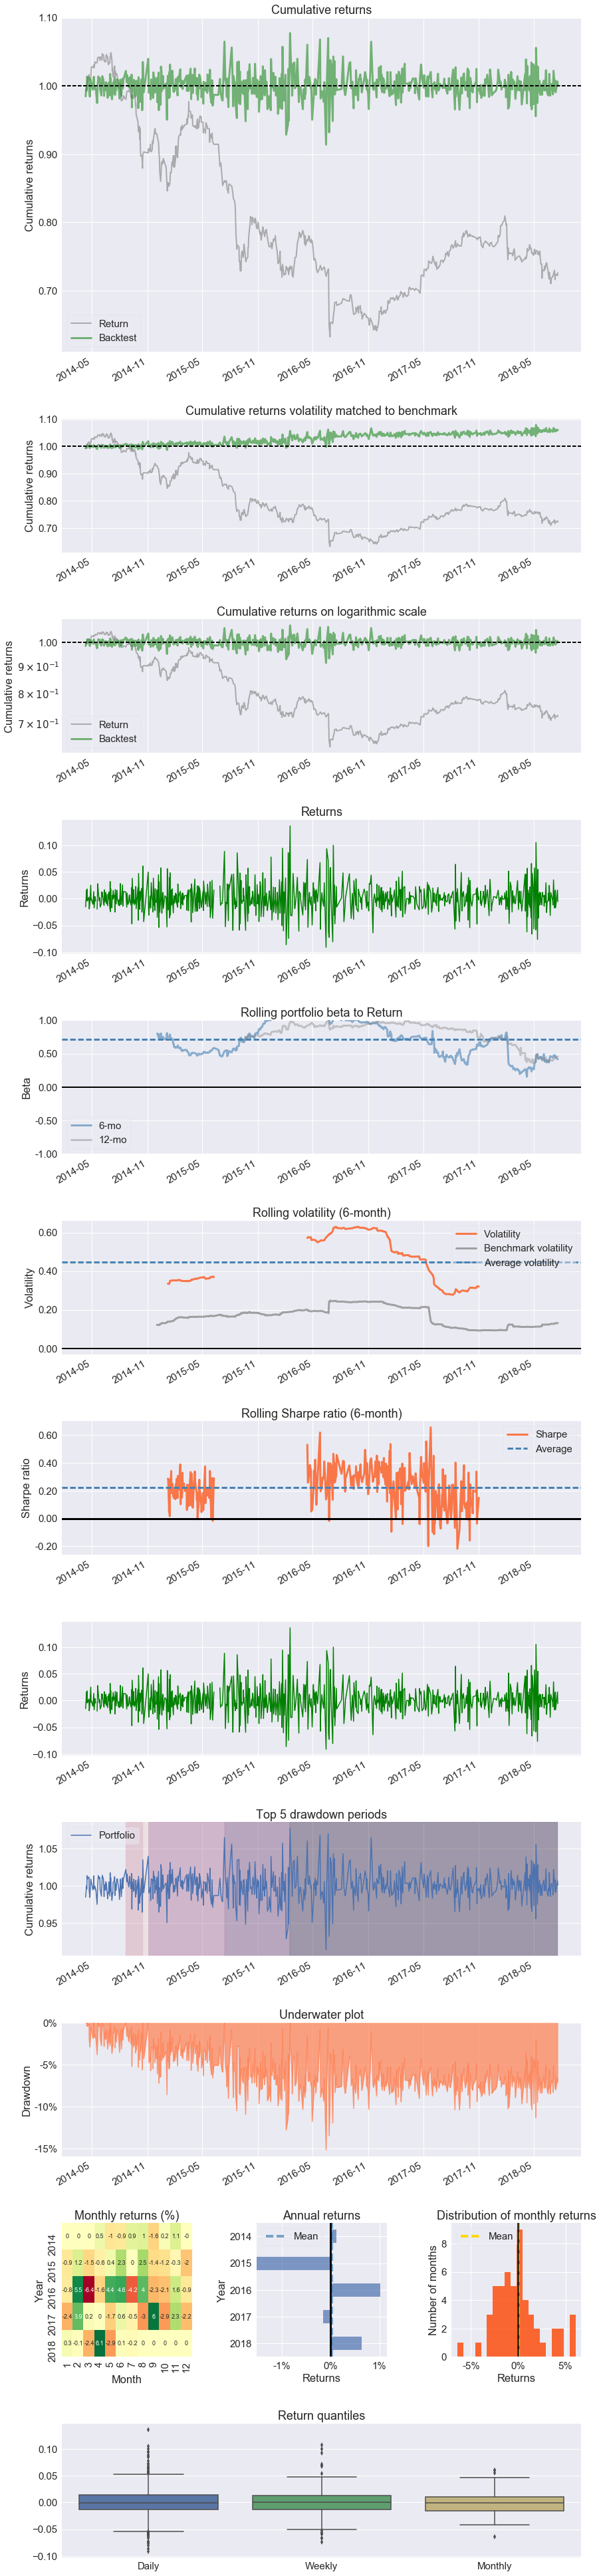

Stress Events,mean,min,max
Apr14,0.05%,-1.92%,2.51%
Oct14,0.06%,-4.30%,6.10%
Fall2015,0.09%,-5.95%,8.55%
New Normal,0.04%,-9.12%,13.59%


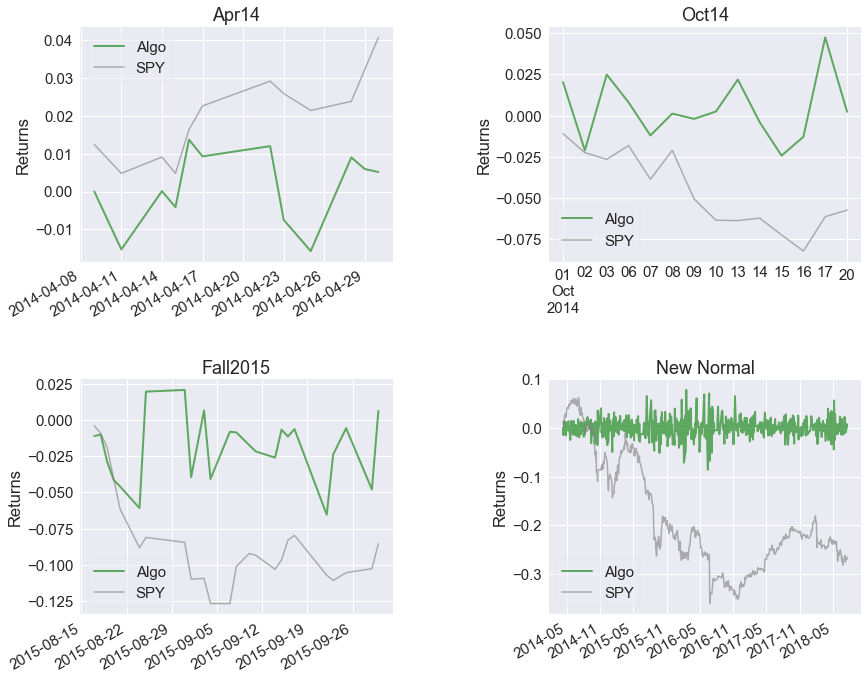

Top 10 long positions of all time,max
SAF,63.52%
ENI,62.95%
SAN,52.22%
ACA,47.71%
BNP,38.57%


Top 10 short positions of all time,max


Top 10 positions of all time,max
SAF,63.52%
ENI,62.95%
SAN,52.22%
ACA,47.71%
BNP,38.57%


All positions ever held,max
SAF,63.52%
ENI,62.95%
SAN,52.22%
ACA,47.71%
BNP,38.57%


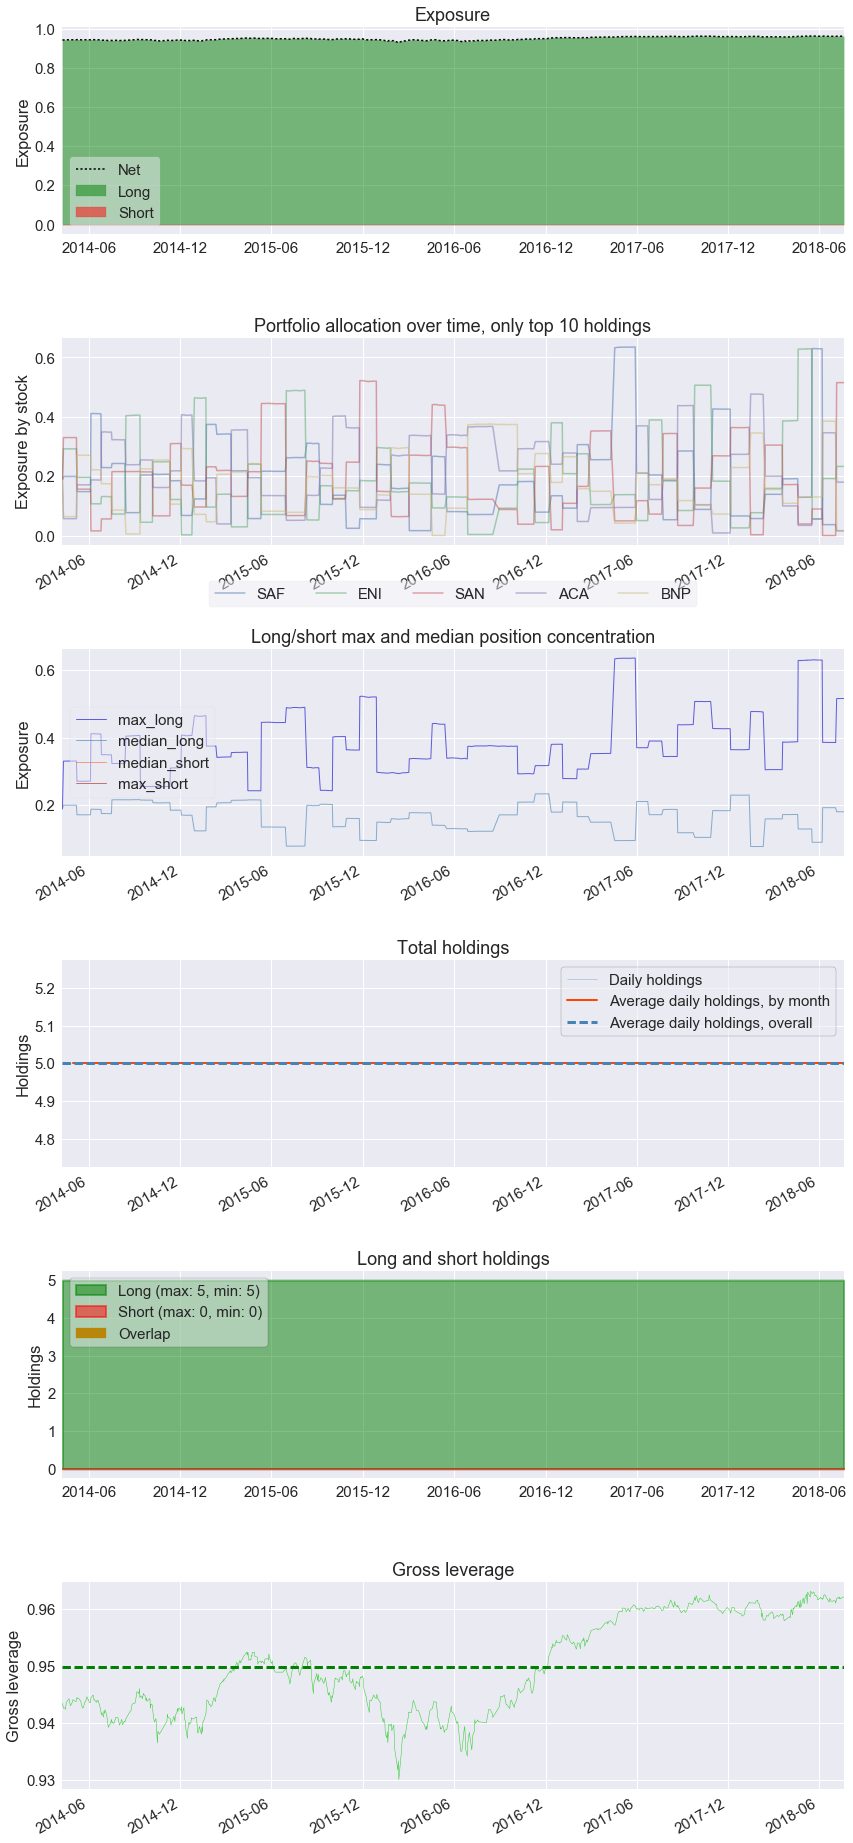

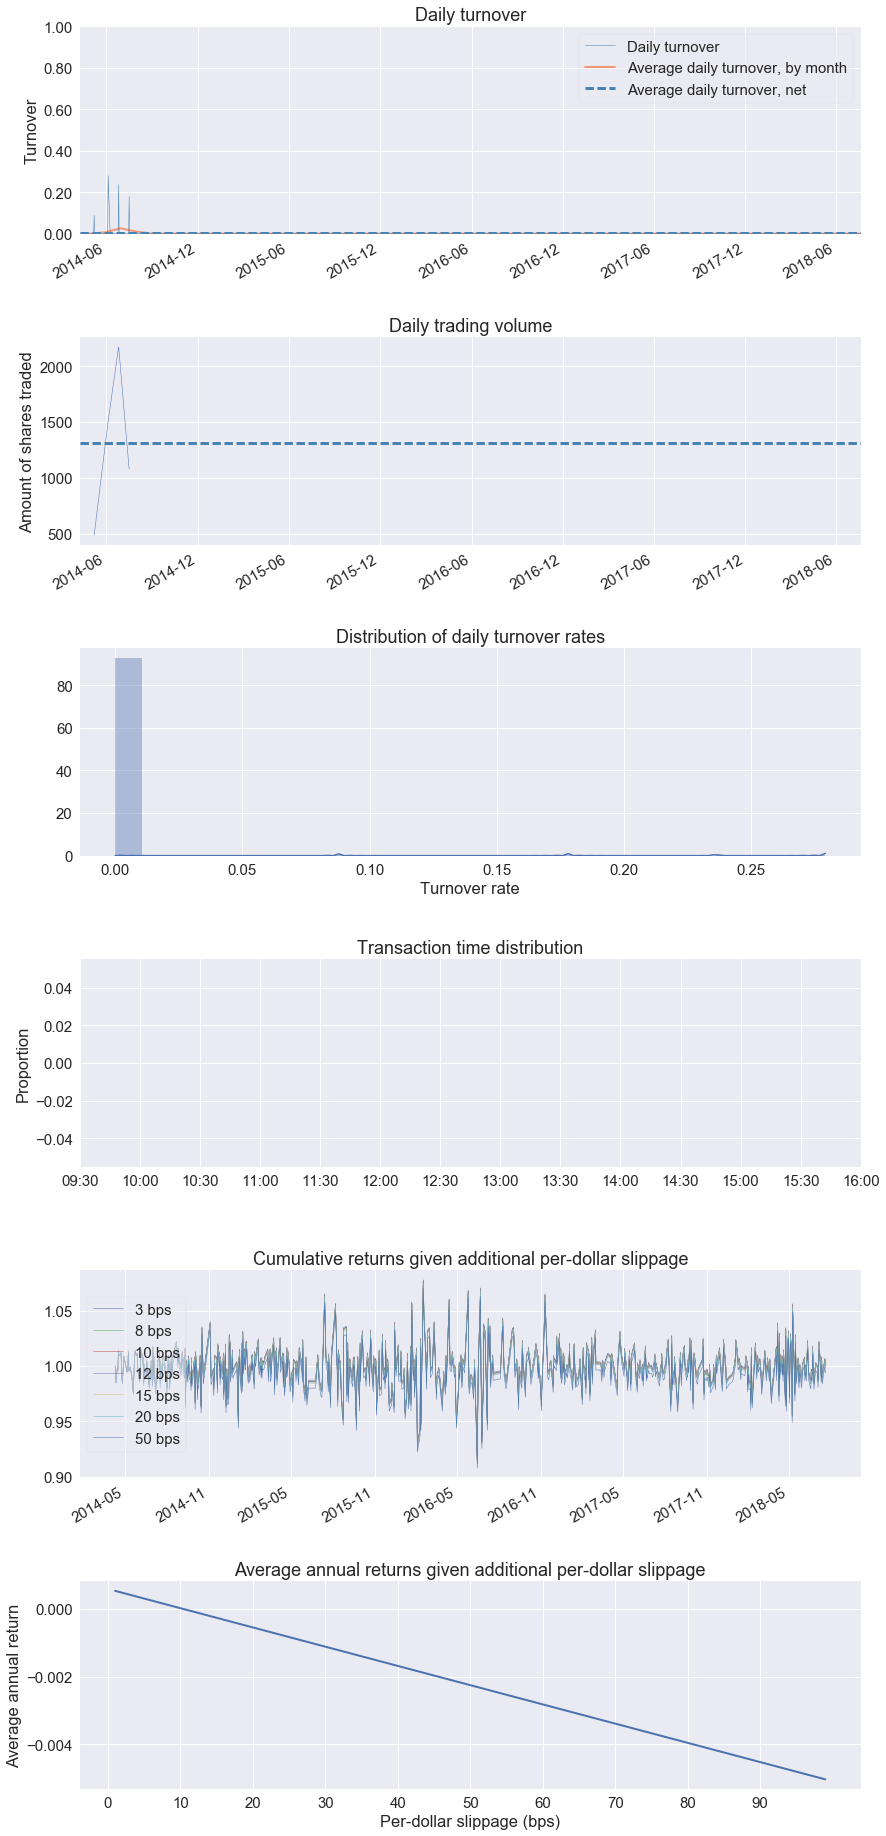

In [327]:
%matplotlib inline
import pyfolio as pf

### FF is faulty so I am replacing it with something else
#pf.plotting.plot_rolling_fama_french = pf.plotting.plot_returns

#pf.create_full_tear_sheet(returns,benchmark_rets=benchmark )

pf.create_full_tear_sheet(returns, positions, transactions, slippage=5,benchmark_rets=benchmark)

In [2]:
import pyfolio as pf

pf.plot_drawdown_periods(returns, top=5).set_xlabel('Date')

/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)
/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


NameError: name 'returns' is not defined

In [ ]:
pd.pivot_table(txn_dollars,values = 'Value', index=['Country','Year'], columns = 'Indicator').reset_index()

In [76]:
alloc_ret["Cummulative Product"]

Date
2014-03-18    1.011556
2014-03-21    1.026881
2014-03-24    1.024723
2014-03-25    1.036592
2014-03-26    1.031797
2014-03-27    1.023755
2014-03-28    1.028668
2014-03-31    1.030324
2014-04-01    1.046784
2014-04-02    1.051025
2014-04-03    1.061401
2014-04-04    1.062027
2014-04-07    1.052410
2014-04-09    1.041134
2014-04-11    1.029104
2014-04-14    1.021875
2014-04-15    1.013940
2014-04-16    1.033477
2014-04-17    1.043315
2014-04-22    1.054386
2014-04-23    1.041064
2014-04-25    1.026644
2014-04-28    1.033084
2014-04-29    1.039855
2014-04-30    1.042534
2014-05-05    1.025787
2014-05-07    1.033086
2014-05-08    1.047009
2014-05-09    1.041218
2014-05-12    1.043721
                ...   
2018-05-25    1.247382
2018-05-28    1.211846
2018-05-29    1.192374
2018-05-30    1.199344
2018-05-31    1.181533
2018-06-04    1.209533
2018-06-05    1.194562
2018-06-06    1.195149
2018-06-07    1.201791
2018-06-08    1.194964
2018-06-11    1.223362
2018-06-13    1.219968
2018-0

In [75]:
port.head()

,ENI,SAN,SAF,BNP,ACA
Date,,,,,
2014-03-18,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
2014-03-21,11819.210156,2349.610885,50788.876643,6266.414891,28775.887425
2014-03-24,11819.210156,2349.610885,50788.876643,6266.414891,28775.887425
2014-03-25,11819.210156,2349.610885,50788.876643,6266.414891,28775.887425
2014-03-26,11819.210156,2349.610885,50788.876643,6266.414891,28775.887425
